In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
plt.style.use(['science', 'notebook'])
from openpyxl import load_workbook
import imageio
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize

Load spreadsheets

In [2]:
def get_data_datasheet(file, sheet, skiprows, usecols, nrows, add_init=None):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return np.append(add_init[0], idx), np.append(add_init[1], arr), 

def get_interp_datasheet_1D(file, sheet, skiprows, usecols, nrows, add_init=None, scale=1):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()/scale
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    if add_init:
        idx = np.insert(idx,0,add_init[0])
        arr = np.insert(arr,0,add_init[1])
    #return interp1d(idx, arr, kind='linear', bounds_error=False, fill_value=(arr.ravel()[0], arr.ravel()[-1]))
    return np.vectorize(interp1d(idx, arr, kind='linear', bounds_error=False, fill_value='extrapolate'))

def get_interp_datasheet_2D(file, sheet, skiprows, usecols, nrows, scale=1):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy()/scale
    idx1 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[2], nrows=nrows[2], usecols=usecols[2]).to_numpy().ravel()
    idx2 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return np.vectorize(interp2d(idx1, idx2, arr))


Get interpolation functions

In [3]:
# Arguments: rd, d
TMR_int = get_interp_datasheet_2D('DATA1.xlsm', '6 MV TMR', skiprows=[3,3,2],
                                     usecols=['B:K', 'A', 'B:K'], nrows=[40,40,1])
# Arguments: rd
Sp_int = get_interp_datasheet_1D('DATA1.xlsm', 'Linac outputs', skiprows=[28, 27],
                                     usecols=['C:L', 'C:L'], nrows=[1,1])
# Arguments: Yc, Xc
Sc_int = get_interp_datasheet_2D('DATA1.xlsm', 'Linac outputs', skiprows=[3,2,3],
                                 usecols=['D:L', 'D:L', 'C'], nrows=[9,1,9])
# Arguments: r, d
PDD_int = get_interp_datasheet_2D('DATA1.xlsm', '6 MV PDD', skiprows=[3,3,2],
                                     usecols=['B:K', 'A', 'B:K'], nrows=[40,40,1],
                                 scale=100)
# Arguments: r, d
PDD18_int = get_interp_datasheet_2D('DATA1.xlsm', '18 MV PDD', skiprows=[3,3,1],
                                     usecols=['B:K', 'A', 'B:K'], nrows=[28,28,1],
                                 scale=100)

# Arguments: d
PDD9e_int = get_interp_datasheet_1D('DATA3.xlsm', '9 MeV PDD', skiprows=[8,8],
                                     usecols=['C', 'A'], nrows=[75,75],
                                 scale=100)

# Arguments: d
PDD20e_int = get_interp_datasheet_1D('DATA3.xlsm', ' 12-20 MeV PDD', skiprows=[8,8],
                                     usecols=['D', 'A'], nrows=[75,75],
                                 scale=100)

# Arguments: d, x
OAR_int = get_interp_datasheet_2D('DATA2.xlsm', '6 MV OARs', skiprows=[4,4,3],
                                     usecols=['B:E', 'A', 'B:E'], nrows=[21,21,1])
# Arguments: theta, p
WF_int = get_interp_datasheet_2D('DATA2.xlsm', '6MV Dynamic WF', skiprows=[5,5,4],
                                     usecols=['B:H', 'A', 'B:H'], nrows=[21,21,1])
# Arguments: d, x
WOAR15_int = get_interp_datasheet_2D('DATA2.xlsm', '6 MV OARs', skiprows=[4,4,3],
                                     usecols=['H:K', 'A', 'H:K'], nrows=[21,21,1])

# Question 1

## Part A

The dose at point $Q$ (purple) is the sum from both diagrams below:

<p align="center">
  <img src="images/a4p1.png" alt="drawing" width="500" align="center"/>
</p>

**Above**:

$$D_N' = \text{WF}(\theta=15^{\circ}, p=0) \cdot S_c(r_c=15)S_p(r_d=15) \cdot 1~\text{cGy/MU}$$
$$D_Q' = \text{TMR}(d=13, r_d=15) \cdot \text{WOAR}(x=7.5, d=13) D_N'$$

**Below**:

$$D_N' = \cdot S_c(r_c=15)S_p(r_d=15) \cdot 1~\text{cGy/MU}$$
$$D_Q' = \text{TMR}(d=13, r_d=15) \cdot \text{OAR}(x=7.5, d=13) \left(\frac{\text{TMR}(d_m+d_2+d_3, r_d)}{\text{TMR}(d_m+d_3, r_d)}\right)^{\rho_e-1} \cdot D_N'$$

In [4]:
DNp_above = WF_int(15, 0) * Sc_int(15,15) * Sp_int(15)
DQp_above = TMR_int(15,13) * WOAR15_int(13, 7.5) * DNp_above

DNp_below = Sc_int(15,15) * Sp_int(15)
CF = (TMR_int(15, 5.5+5)/TMR_int(15,5))**(0.25-1)
DQp_below = TMR_int(15,13) * OAR_int(13, 7.5)* CF * DNp_below 

Since the weighting factor (TMR) between beams is 1

$$\dot{D}_N^{(above)}MU_{above} -  \dot{D}_N^{(below)}MU_{below} = 0$$
$$\dot{D}_Q^{(above)}MU_{above} + \dot{D}_Q^{(below)}MU_{below} = 300$$

This can be setup as a matrix equation, and the monitor units can be solved for

In [5]:
A = np.array([[DNp_above[0],-DNp_below[0]],
              [DQp_above[0], DQp_below[0]]])
b = np.array([0,300])
MUabove, MUbelow = np.linalg.inv(A)@b

Print number of monitor units:

In [6]:
print(f'Number of monitor units per fraction above {MUabove:.2f}MU')
print(f'Number of monitor units per fraction below {MUbelow:.2f}MU')

Number of monitor units per fraction above 192.00MU
Number of monitor units per fraction below 193.15MU


## Part B

The dose point is located near the center of the patient so it is likely that this treatment is for the cancer of an internal organ. The purpose of the wedge on the upper field is likely to minimize dose to breast tissue, as this may cause biological consequences for the patient later on. The assmetric collimation permits central alignment of the patient while still avoiding dose to the spinal cord.

# Question 2

## Part A

<p align="center">
  <img src="images/a4p2.png" alt="drawing" width="300" align="center"/>
</p>

The gantry needs to be tilted by an angle 

$$\theta = \tan^{-1}\left( \frac{Y_2^{(\text{init})}}{SAD}\right) $$

In [7]:
theta = np.arctan(18/100)
print(f'Theta = {theta*180/np.pi:.2f} degrees')

Theta = 10.20 degrees


(counter clockwise in the main diagram of question 2)

## Part B

<p align="center">
  <img src="images/a4p3.png" alt="drawing" width="600" align="center"/>
</p>

The goal of this problem is to solve for $Y_2$ given $SAD$, $Y_0$, $d_A$, $d_B$, $h$, and $L$. First note the following relations:

* $Y_0' = Y_0\frac{SAD+h+d_A}{SAD}$
* $D = \sqrt{Y_0'^2 + (SAD+h+d_A)^2}$
* $a = L - 2Y_0'$
* $SAD+h+d_A - b$
* $\tan^{-1}((Y_0'+a)/(SAD+h+d_B)) = \theta+\mu$
* $\tan(\mu) = Y_2/SAD$

In [8]:
SAD = 100
Y0 = 18
dA = 11.5
dB = 3
h = 30
L = 59
Y0p = Y0 * (SAD+h+dA)/SAD
D = np.sqrt(Y0p**2 + (SAD+h+dA)**2)
a = L-2*Y0p
b = dA-dB
mu = np.arctan((Y0p+a)/(SAD+h+dB)) - theta
Y2 = SAD*np.tan(mu)

Let minimize to get the optimal value of Y2

In [9]:
print(f'Value of Y2: {Y2:.2f}cm')

Value of Y2: 6.90cm


## Part C

We have

$$D' = {}_S D_N' \cdot PDD(d,r,SSD_0) \left( \frac{SSD+d_m}{SSD+d} \frac{SSD_0+d}{SSD_0+d_m}\right)^2  $$

where, in the following, ${}^{(0)}$ refers to at $SSD_0$

$${}_S D_N' = \frac{S_p(r_d)}{S_p(r_d^{(0)})} \left( \frac{SSD_0+d_m}{SSD+d_m} \right)^2 S_c(r^{(0)})S_p(r_d^{(0)}) \cdot 1\text{cGy/MU}$$

Furthermore, if $r_d=12~$cm then $r=r_d \frac{SSD_0}{SSD+d}$

In [10]:
D = 180
d = 5
dm =1.5
SSD = 130.2
SSD0 = 100
rd = 12
rd0 = (SSD0+d)/(SSD+d) *rd
r = rd * (SSD/(SSD+d))
r0 = r * SSD0/SSD

MF = ((SSD+1.5)/(SSD+d))**2 * ((SSD0+d)/(SSD0+1.5))**2
IVL = (SSD0+dm)**2 / (SSD+dm)**2

Compute $D'$

In [11]:
sDNp = Sp_int(rd)/Sp_int(rd0) * IVL * Sc_int(r0,r0) * Sp_int(rd0)
Dp = sDNp * PDD_int(rd, d) * MF

Compute monitor units

In [12]:
MU = D/Dp
print(f'Number of monitor units required: {MU[0]:.2f} MU')

Number of monitor units required: 343.10 MU


## Part D

Assuming the right boundary of the of the brain field is setup to coincide with the boundary of the spine field at all depths, we must have

$$\theta_c = \tan^{-1}(Y_0/SAD)$$

which is pricesly the same angle as the gantry tilt before (only this time the collimators must be rotated **clockwise** in the main image reference frame)

In [13]:
print(f'Theta = {theta*180/np.pi:.2f} degrees')

Theta = 10.20 degrees


## Part E

Since this problem is symmetric, we can consider how many monitor units are required to give 90cGy from one beam. We have

$$D' = S_c(r_c)S_p(r_d) \cdot TMR(d_b, r_d)OAR(x_b, d_b)$$

Since the field is unwedged, the off-axis distance, x, 
is determined by measuring radially from the CAX to the point of interest.

In [14]:
db = 8
rd = 20
xb = 9.3
Yc = 24
Xc = 30

Thus

In [15]:
Dp = Sc_int(Yc, Xc)*Sp_int(rd)*TMR_int(rd,db)*OAR_int(db,xb)

And the monitor units is given by

In [16]:
MU = 90 / Dp
print(f'Number of monitor units required: {MU[0]:.2f} MU')

Number of monitor units required: 95.11 MU


# Question 3

The equation for the dose at all the points is given by:

$${}_sD_N' = \text{WF}(\theta=15^{\circ}, p=0) \cdot S_c(r_c=8\times 10)S_p(r_d) \cdot 1~\text{cGy/MU}$$

$$D_Q' = \text{PDD}(d=d_Q, r) \cdot \left(\frac{\text{TMR}(d_{eff}^{(Q)}, r_Q)}{\text{TMR}(d^{(Q)}, r_Q)}\right) {}_sD_N'$$

$$D_B' = \text{PDD}(d=d_B, r) \left( \frac{SSD_B+d_m}{SSD_B+d_B} \frac{100+d_B}{100+d_m}\right)^2 \frac{S_p(r)}{S_p(r_{B_s})} \cdot \text{WOAR}(x=x_B, d=d_B) \left(\frac{\text{TMR}(d_{eff}^{(B)}, r_B)}{\text{TMR}(d^{(B)}, r_B)}\right){}_sD_N'$$

$$D_A' = \text{PDD}(d_A, r) \left( \frac{SSD_A+d_m}{SSD_A+d_A} \frac{100+d_A}{100+d_m}\right)^2 \frac{S_p(r)}{S_p(r_{A_s})} \cdot \text{WOAR}(x=x_A, d=d_A) \left(\frac{\text{TMR}(d_{eff}^{(A)}, r_A)}{\text{TMR}(d^{(A)}, r_A)}\right) {}_sD_N'$$

Define all appropriate quantities

In [17]:
rhobone = 1.5
dm=1.5
dQ = 6.6
dA = 6.5
dB = 5.2
deffQ = (dQ-2) + 2*rhobone
deffA = (dA-2) + 2*rhobone
deffB = (dB-2) + 2*rhobone
DeltaA = 7.4-dA
DeltaB = 4.8-dB
rQs = 8.900 
rAs = rQs * (100+DeltaA)/100
rBs = rAs * (100+DeltaA)/100
rQ = rQs * (100+dQ)/100
rA = rAs * (100+DeltaA+dA)/100
rB = rBs * (100+DeltaB+dB)/100
rd = rQs*(100+dm)/100
xA = 3.5 * 100 / (dA+DeltaA+100)
xB = -1.9 * 100 / (dB+DeltaB+100)

Compute dose rates (`p` means "prime")

In [18]:
PDD_CFA = ((100+DeltaA+dm)/(100+DeltaA+dA) * (100+dA)/(100+dm))**2
PDD_CFB = ((100+DeltaB+dm)/(100+DeltaB+dB) * (100+dB)/(100+dm))**2

sDNp = WF_int(15,0) * Sc_int(10,8)*Sp_int(rd)
DQp = PDD_int(rQs,dQ) * (TMR_int(rQ, dQ)/TMR_int(rQ, deffQ))*sDNp
DAp = PDD_int(rAs,dA) * (TMR_int(rA, dA)/TMR_int(rA, deffA))*PDD_CFA*Sp_int(rQs)/Sp_int(rAs)*WOAR15_int(dA, xA)*sDNp
DBp = PDD_int(rBs,dB) * (TMR_int(rB, dB)/TMR_int(rB, deffB))*PDD_CFB*Sp_int(rQs)/Sp_int(rBs)*WOAR15_int(dB, xB)*sDNp

Since 80cGy is delivered, the number of monitor units is

In [19]:
MU = 80 / DQp[0]

And so the dose at $A$ and $B$ is

In [20]:
print(f'Dose at point A: {DAp[0]*MU*0.971:.2f}cGy')
print(f'Dose at point B: {DBp[0]*MU*0.971:.2f}cGy')

Dose at point A: 75.64cGy
Dose at point B: 85.51cGy


# Question 4

Since the setup uses standard beam sizes with no complicated structure, we have

$$D_A^{(\text{photon})} =D_0^{(\text{SSD})'} \cdot PDD_p(d+\Delta_B,10) MU_p$$
$$D_A^{(\text{electron})} = 1\text{cGy/MU} \cdot  PDD_e(d,10) MU_e$$

where $\Delta_B$ is the bolus thickness and $d$ is the depth in the patient. The net percent depth dose is

$$\begin{align*}PDD_{tot} & \propto D_A^{(\text{photon})} + D_A^{(\text{electron})}\\ &= D_0^{(\text{SSD})'} PDD_p(d+\Delta_B,10) MU_p + (1\text{cGy/MU}) PDD_e(d,10) MU_e\\ &\propto D_0^{(\text{SSD})'} PDD(d+\Delta_B,10) \frac{MU_p}{MU_e}+ (1\text{cGy/MU})  PDD(d,10)\end{align*}$$

We then just need to normalize by the appropriate constant to ensure that the maximum percent is 100%. Since each beam gives an equal dose at $d=6.5$cm

$$1 = \frac{D_A^{(\text{photon})}}{D_A^{(\text{electron})}} = \frac{ D_0^{(\text{SSD})'}PDD_p(d+\Delta_B,10) MU_p}{ (1\text{cGy/MU}) PDD_e(d,10) MU_e}$$

we get

$$\frac{MU_p}{MU_e} = \frac{(1\text{cGy/MU}) PDD_e(d,10)}{D_0^{(\text{SSD})'} PDD_p(d+\Delta_B,10)}$$

It follows that 

$$PDD_{tot}  \propto  PDD_p(d+\Delta_B,10) \frac{PDD_e(d,10)}{PDD_p(d+\Delta_B,10)}+ PDD_e(d,10)$$

In [21]:
B = 0.4
d = 6.5
PDD_ratio = PDD20e_int(6.5)/PDD18_int(10,d+B)

Then we can plot

In [22]:
d_small = np.array([0,0.5,1,1.5,2,2.5,3])
PDD_small = np.array([12.2,56.8,81.7,91,96.1,99.2,99.9])/100
d_large = np.linspace(3,20,100)
PDD_large = PDD18_int(10,d_large)
PDD_full_int = interp1d(np.concatenate([d_small, d_large]),
                        np.concatenate([PDD_small, PDD_large]),
                        kind='linear', bounds_error=False)

In [23]:
d = np.linspace(0,20,1000)
PDD = PDD20e_int(d) + PDD_full_int(d+B)*PDD_ratio[0]

Now we need to normalize so that 95% of the prescribed dose corresponds to point A

In [24]:
PPD = PDD * 95/PDD[np.argmin(np.abs(d-6.5))]

Plot

* Shown are the boundaries of the PTV ( red vertical lines) and the 95% isodose (purple horizontal line)

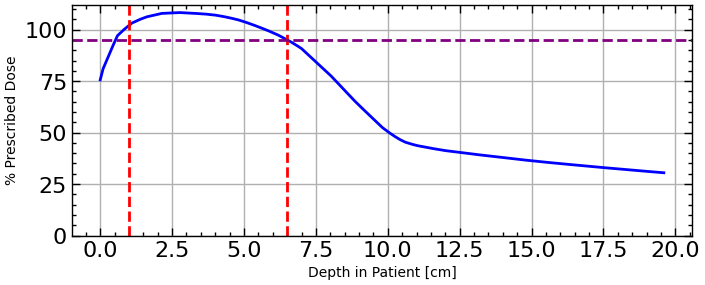

In [25]:
plt.figure(figsize=(8,3))
plt.plot(d, PPD, color='b')
plt.xlabel('Depth in Patient [cm]', fontsize=10)
plt.ylabel('% Prescribed Dose', fontsize=10)
plt.axvline(1, color='r', ls='--')
plt.axvline(6.5, color='r', ls='--')
plt.axhline(95, color='purple', ls='--')
plt.grid()
plt.ylim(bottom=0)
plt.show()

## Part B

The ICRU criteria is that the PTV is covered by the $95\%$ isodose line. As seen in the plot above, The PTV contains above 95% isodose in the entire treatment volume along the central axis. Provided this is also met off-axis throughout the entire PTV, **the ICRU criteria is satisfied**.

# Question 5

## Part A

We can express this quantity as

$$\begin{align*} \frac{2|D_A-D_B|}{D_A+D_B} &= 2\frac{\left|(D(0)-D(d)) + \left(D_A^{(b)}(0,\delta) -D_B^{(b)}(d,\delta)\right)\right|}{(D(0)+D(d)) + \left(D_A^{(b)}(0,\delta) + D_B^{(b)}(d,\delta)\right)}\\ & =2\frac{\left|1-D(d)/D(0)) + \left(D_A^{(b)}(0,\delta)/D(0) -D_B^{(b)}(d,\delta)/D(0)\right)\right|}{(1+D(d)/D(0)) + \left(D_A^{(b)}(0,\delta)/D(0) + D_B^{(b)}(d,\delta)/D(0)\right)}\\ \end{align*}$$

where

* $\frac{D(d)}{D(0)} = \frac{\text{PDD}(d)}{\text{PDD}(0)}$

* $\frac{D^{(b)}(d,\delta)}{D(0)} = \frac{D_b(0)e^{-k(\delta+\Delta-d)}}{D(0)} = \frac{D(d^{(i)})(EBF-1)e^{-k(\delta+\Delta-d)}}{D(0)} = \frac{\text{PDD}(d^{(i)}) (EBF-1)e^{-k(\delta+\Delta-d)}}{\text{PDD}(0)}  $

and further, where...

* $EBF = 1+0.735e^{-0.052E(Delta+\delta)}$
* $k = 6.1(E(\delta+\Delta))^{-0.62}$
* $E(d) = E(0)(1-d/R_p)$
* $d^{(i)}$ is the depth to tungesten
* $\Delta=0.3$mm

Required functions

In [26]:
def get_Ed(d, E0=9, Rp=4.5):
    return E0*(1-d/Rp)

def get_EBF(d):
    return 1+0.735*np.exp(-0.052*get_Ed(d))

def get_k(x):
    return 6.1*(get_Ed(x))**(-0.62)

def get_backratio(d, delta):
    EBF = get_EBF(0.3+delta)
    k = get_k(0.3+delta)
    return PDD_ratio(0.3+delta)*(EBF-1)*np.exp(-k*(0.3+delta-d))

def PDD_ratio(d):
    return PDD9e_int(d)/PDD9e_int(0)

def minimizer(dA, dB, delta):
    numerator = (1-PDD_ratio(dB)) + (get_backratio(dA, delta) - get_backratio(dB, delta))
    denominator = (1+PDD_ratio(dB)) + (get_backratio(dA, delta) + get_backratio(dB, delta))
    return 2*np.abs(numerator)/denominator

Get some values and plot

In [27]:
deltas = np.linspace(0,4,1000)
mins = minimizer(0,0.3,deltas)

Plot

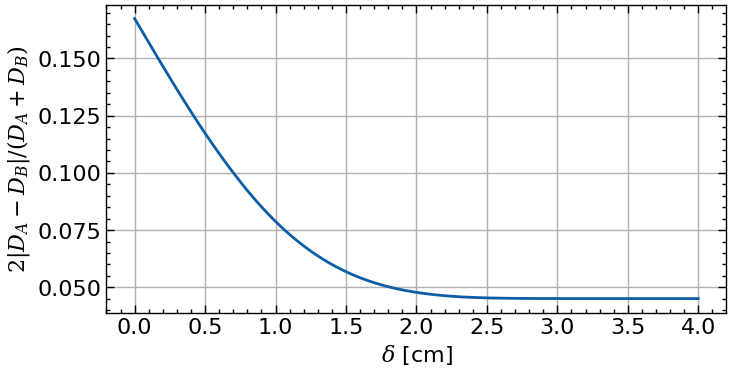

In [28]:
plt.figure(figsize=(8,4))
plt.plot(deltas, mins)
plt.xlabel('$\delta$ [cm]')
plt.ylabel('$2|D_A-D_B|/(D_A+D_B)$')
plt.grid()
plt.show()

Lets find the minimum value of $\delta$ that makes this quantity less than 0.12

In [29]:
delta_min = deltas[mins<=0.12][0]
print(f'The minimum value of delta is {10*delta_min:.2f}mm')

The minimum value of delta is 4.72mm


## Part B

The **effective distance** of a material is $\rho \cdot x$. So to have equal effective distances $\rho_w x_w = \rho_a x_a$ and thus $x_a= \frac{\rho_w}{\rho_a}x_w$

In [30]:
rho_a = 2.718
rho_w = 1
x_a = rho_w/rho_a * delta_min
print(f'Required distance of aluminum = {10*x_a:.2f}mm')

Required distance of aluminum = 1.74mm


## Part C

Since this is an SSD setup under standard conditions with backscatter

$$D_i' = \left(PDD(d_i) \cdot 1~\text{cGy/MU}\right) + \left((EBF-1)e^{-k(\delta+\Delta-d)} \cdot 1~\text{cGy/MU}\right)$$

and $D_i = D_i' \cdot MU$. For our two points then

$$MU = \frac{2}{D_A'+D_b'} \cdot 200~\text{cGy}$$

In [31]:
def get_scatter(d, delta):
    EBF = get_EBF(d)
    k = get_k(d)
    return PDD9e_int(d)*(EBF-1)*np.exp(-k*(0.3+delta-d))

Compute quantities

In [32]:
DAp = PDD9e_int(0) + get_scatter(0, delta_min)
DBp = PDD9e_int(0.3) + get_scatter(0.3, delta_min)
MU = 2/(DAp+DBp) * 200

Print number of monitor units required.

In [33]:
print(f'Number of monitor units required: {MU:.2f}MU')

Number of monitor units required: 212.45MU
